<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Контекст" data-toc-modified-id="Контекст-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Контекст</a></span></li><li><span><a href="#Методология" data-toc-modified-id="Методология-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Методология</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обработка данных</a></span></li><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li></ul></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выбор модели</a></span></li><li><span><a href="#Тест-модели-и-выводы" data-toc-modified-id="Тест-модели-и-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тест модели и выводы</a></span></li><li><span><a href="#Отчет-по-проекту" data-toc-modified-id="Отчет-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Отчет по проекту</a></span></li></ul></div>

## Описание проекта

### Контекст

**Бизнес-задача:** минимизация издержек производства стали, путем снижения потребления электроэнергии.   

**Процесс производства**   
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**   
Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Методология

**Цель проекта:** построить модель, предсказывающую температуру стали.

**Предположения**   
Что влияет на температуру:
1. Первичное значение измерения.
2. Как долго шел нагрев и с какой мощностью.
3. Что добавлялось из материалов, проволоки и в каких объемах.
4. Объем газа при продувке

**План действий**   
1. Агрегировать данные по материалам, проволоке и нагреву в разрезе партий, суммируя значения.
2. Для каждой партии рассчитать начальное и конечное значения измерения температуры.
3. Оставить в датасете только те наблюдения, которые содержат как начальное измерение, так и конечное в силу отсутствия достоверных данных по первичному состоянию.
4. Провести первичный анализ данных на соответствие типам данных, дубликаты, пропуски, очистить от выбросов.
5. Провести корреляционный анализ и убрать зависимые факторы.
6. Подобрать наилучшую модель, исходя из выбранных метрик.

**Используемые методы**   
Модели:
1. Линейная регрессия
2. Полиномиальная регрессия
3. Случайный лес с подбором гиперпараметров
4. KNN

Метрики:   
- MAE с референтным значением - 6.8
- R$^2$

## Исследовательский анализ данных

### Обработка данных

Импортируем все необходимые библиотеки для дальнейшей работы и считаем данные.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')

**data_bulk & data_bulk_time**

Датасеты содержат информацию об использованных материалах в разрезе партий: первый о количестве, второй о времени. Поскольку нас интересует суммарный объем использованных материалов в разрезе партий, а не время их применения, data_bulk_time можно убрать из анализа.

In [3]:
#создадим список всех наименований материалов
ls = []
for i in range(1, 16):
    txt = 'Bulk ' + str(i)
    ls.append(txt)

#приведем data_bulk к табличному виду
data_bulk_main = pd.melt(
    data_bulk, 
    id_vars=['key'], 
    value_vars=ls
).dropna().sort_values(by=['key', 'variable']).reset_index(drop=True)

data_bulk_main.columns = ['key', 'bulk', 'bulk_amount']
data_bulk_main['bulk'].value_counts()

Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
Name: bulk, dtype: int64

Можно заметить, что есть большое кол-во категорий, которые использовались менее 500 раз. Для получения более устойчивых оценок параметров заменим эти категории на 'bulk_other'

In [4]:
ls = data_bulk_main['bulk'].value_counts().head(6).index
for i in range(len(data_bulk_main)):
    if data_bulk_main['bulk'][i] not in ls:
        data_bulk_main['bulk'][i] = 'bulk_other'
data_bulk_main['bulk'].value_counts()

Bulk 14       2806
Bulk 12       2450
Bulk 15       2248
Bulk 3        1298
Bulk 4        1014
bulk_other     767
Bulk 6         576
Name: bulk, dtype: int64

Далее приведем к табличному виду, чтобы категории материалов можно было в дальнейшем рассматривать как факторы.

In [5]:
data_bulk_main = data_bulk_main.pivot_table(
    index=['key'], 
    columns=['bulk'],
    values=['bulk_amount'], 
    aggfunc='sum'
).reset_index().fillna(0)
data_bulk_main.columns = ['key', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_oth']

<code style="background:green;color:white">Итоговый вид</code>

In [6]:
data_bulk_main.head()

,key,bulk_12,bulk_14,bulk_15,bulk_3,bulk_4,bulk_6,bulk_oth
0,1,206.0,150.0,154.0,0.0,43.0,0.0,0.0
1,2,206.0,149.0,154.0,0.0,73.0,0.0,0.0
2,3,205.0,152.0,153.0,0.0,34.0,0.0,0.0
3,4,207.0,153.0,154.0,0.0,81.0,0.0,0.0
4,5,203.0,151.0,152.0,0.0,78.0,0.0,0.0


**data_wire & data_wire_time**

Аналогично data_bulk приведем данные к табличному виду.

In [7]:
#создадим список всех наименований материалов
ls = []
for i in range(1, 10):
    txt = 'Wire ' + str(i)
    ls.append(txt)

#приведем data_wire к табличному виду
data_wire_main = pd.melt(
    data_wire, 
    id_vars=['key'], 
    value_vars=ls
).dropna().sort_values(by=['key', 'variable']).reset_index(drop=True)

data_wire_main.columns = ['key', 'wire', 'wire_amount']
data_wire_main['wire'].value_counts()

Wire 1    3055
Wire 2    1079
Wire 6      73
Wire 3      63
Wire 9      29
Wire 8      19
Wire 4      14
Wire 7      11
Wire 5       1
Name: wire, dtype: int64

Абсолютно по той же логике заменим все категории, кроме 'Wire 1' и 'Wire 2', на 'wire_other'.

In [8]:
ls = data_wire_main['wire'].value_counts().head(2).index
for i in range(len(data_wire_main)):
    if data_wire_main['wire'][i] not in ls:
        data_wire_main['wire'][i] = 'wire_other'
data_wire_main['wire'].value_counts()

Wire 1        3055
Wire 2        1079
wire_other     210
Name: wire, dtype: int64

Далее приведем к табличному виду, чтобы категории проволоки можно было в дальнейшем рассматривать как факторы.

In [9]:
data_wire_main = data_wire_main.pivot_table(
    index=['key'], 
    columns=['wire'],
    values=['wire_amount'], 
    aggfunc='sum'
).reset_index().fillna(0)
data_wire_main.columns = ['key', 'wire_1', 'wire_2', 'wire_oth']

<code style="background:green;color:white">Итоговый вид</code>

In [10]:
data_wire_main.head()

,key,wire_1,wire_2,wire_oth
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0


**data_arc**

Переименуем столбцы, а также рассчитаем длительность нагрева.

In [11]:
# data_arc
data_arc_main = data_arc.copy()
data_arc_main.columns = ['key', 'time', 'arc_time_end', 'act_power', 'react_power']
data_arc_main['time'] = pd.to_datetime(
    data_arc_main['time'], 
    format='%Y-%m-%d %H:%M:%S'
)
data_arc_main['arc_time_end'] = pd.to_datetime(
    data_arc_main['arc_time_end'], 
    format='%Y-%m-%d %H:%M:%S'
)
data_arc_main['duration_sec'] = (
    (data_arc_main['arc_time_end'] - data_arc_main['time'])/ np.timedelta64(1, 's')
)

Агрегируем данные в разрезе партий.

In [12]:
data_arc_main = data_arc_main.pivot_table(
    index='key', 
    values=['act_power', 'react_power', 'duration_sec'], 
    aggfunc='sum'
).reset_index()

<code style="background:green;color:white">Итоговый вид</code>

In [13]:
display(data_arc_main.head())

,key,act_power,duration_sec,react_power
0,1,4.878147,1098.0,3.183241
1,2,3.052598,811.0,1.998112
2,3,2.525882,655.0,1.599076
3,4,3.209250,741.0,2.060298
4,5,3.347173,869.0,2.252643


**data_gas**

Переименуем столбцы для дальнейшей работы.

In [14]:
data_gas_main = data_gas.copy()
data_gas_main.columns = ['key', 'gas']

<code style="background:green;color:white">Итоговый вид</code>

In [15]:
data_gas_main.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


**data_temp**

В датасете присутствует 2 категории наблюдений, которые не вписываются в предлагаемую модель:
1. Партии, для которых есть всего 1 измерение температуры
2. Партии, у которых проводились измерения температуры, но по какой-то причине не были зафиксированы.

Соответственно, для дальнейшей модели оставим только те наблюдения, которые имеют измерение температуры на входе и на выходе. Таким образом, модель будет способна предсказать температуру после первичного измерения и предполагаемого вмешательства в виде подогрева и добавления материалов.

In [16]:
#список партий с пропущенными значениями
ls_missed = data_temp[data_temp['Температура'] != data_temp['Температура']]['key'].value_counts().index
ls_ttl = data_temp['key'].value_counts().index
print(f'Доля партий с пропусками: {(len(ls_missed) / len(ls_ttl)):.1%}')

Доля партий с пропусками: 23.0%


In [17]:
#список партий с единственным измерением
ls_one = data_temp['key'].value_counts()[data_temp['key'].value_counts() == 1].index
print(f'Доля партий с единственным измерением: {(len(ls_one) / len(ls_ttl)):.1%}')

Доля партий с единственным измерением: 0.1%


In [18]:
#очистим датасет
data_temp = data_temp[~data_temp['key'].isin(ls_missed)]
data_temp = data_temp[~data_temp['key'].isin(ls_one)]

Для каждой партии найдем начальное и конечное измерение температуры.

In [19]:
data_temp.columns = ['key', 'time', 'temp']
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')

data_temp_pivot = data_temp.pivot_table(
    index=['key'], 
    values=['time'],
    aggfunc=['min', 'max']
).reset_index()

data_temp_pivot.columns = ['key', 'time', 'last']
data_temp_pivot = pd.merge(data_temp_pivot, data_temp, on=['key', 'time'])

data_temp_pivot.columns = ['key', 'first', 'time', 'first_temp']
data_temp_pivot = pd.merge(data_temp_pivot, data_temp, on=['key', 'time'])

data_temp_main = data_temp_pivot.drop(['first', 'time'], axis=1)
data_temp_main.columns = ['key', 'first_temp', 'last_temp']

<code style="background:green;color:white">Итоговый вид</code>

In [20]:
data_temp_main.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


**Сведение всех действий в единый датасет**

Теперь соберем все полученные таблицы в единый датасет.

In [21]:
df = pd.merge(data_temp_main, data_bulk_main, on=['key'], how='left').merge(
    data_wire_main, on=['key'], how='left').merge(
    data_arc_main, on=['key'], how='left').merge(
    data_gas_main, on=['key'], how='left')

<code style="background:green;color:white">Итоговый вид</code>

In [22]:
df.head()

,key,first_temp,last_temp,bulk_12,bulk_14,bulk_15,bulk_3,bulk_4,bulk_6,bulk_oth,wire_1,wire_2,wire_oth,act_power,duration_sec,react_power,gas
0,1,1571.0,1613.0,206.0,150.0,154.0,0.0,43.0,0.0,0.0,60.059998,0.00000,0.0,4.878147,1098.0,3.183241,29.749986
1,2,1581.0,1602.0,206.0,149.0,154.0,0.0,73.0,0.0,0.0,96.052315,0.00000,0.0,3.052598,811.0,1.998112,12.555561
2,3,1596.0,1599.0,205.0,152.0,153.0,0.0,34.0,0.0,0.0,91.160157,0.00000,0.0,2.525882,655.0,1.599076,28.554793
3,4,1601.0,1625.0,207.0,153.0,154.0,0.0,81.0,0.0,0.0,89.063515,0.00000,0.0,3.209250,741.0,2.060298,18.841219
4,5,1576.0,1602.0,203.0,151.0,152.0,0.0,78.0,0.0,0.0,89.238236,9.11456,0.0,3.347173,869.0,2.252643,5.413692


### Первичный анализ данных

In [23]:
df = df.drop(['key'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2475 non-null   float64
 1   last_temp     2475 non-null   float64
 2   bulk_12       2407 non-null   float64
 3   bulk_14       2407 non-null   float64
 4   bulk_15       2407 non-null   float64
 5   bulk_3        2407 non-null   float64
 6   bulk_4        2407 non-null   float64
 7   bulk_6        2407 non-null   float64
 8   bulk_oth      2407 non-null   float64
 9   wire_1        2372 non-null   float64
 10  wire_2        2372 non-null   float64
 11  wire_oth      2372 non-null   float64
 12  act_power     2475 non-null   float64
 13  duration_sec  2475 non-null   float64
 14  react_power   2475 non-null   float64
 15  gas           2473 non-null   float64
dtypes: float64(16)
memory usage: 328.7 KB


In [24]:
df.duplicated().sum()

0

**Вывод:**   
1. Показатели first_temp, last_temp, duration_sec необходимо привести к типу integer.
2. Дубликатов нет.
3. Все пропуски в переменных bulk, wire, gas означают отсутствие вещества в партии -> их можно заменить на 0.

In [25]:
df['duration_sec'] = df['duration_sec'].astype(int)
df['first_temp'] = df['first_temp'].astype(int)
df['last_temp'] = df['last_temp'].astype(int)
df = df.fillna(0)

**Распределения и выбросы**

Проанализируем наличие выбросов с помощью графика boxplot.

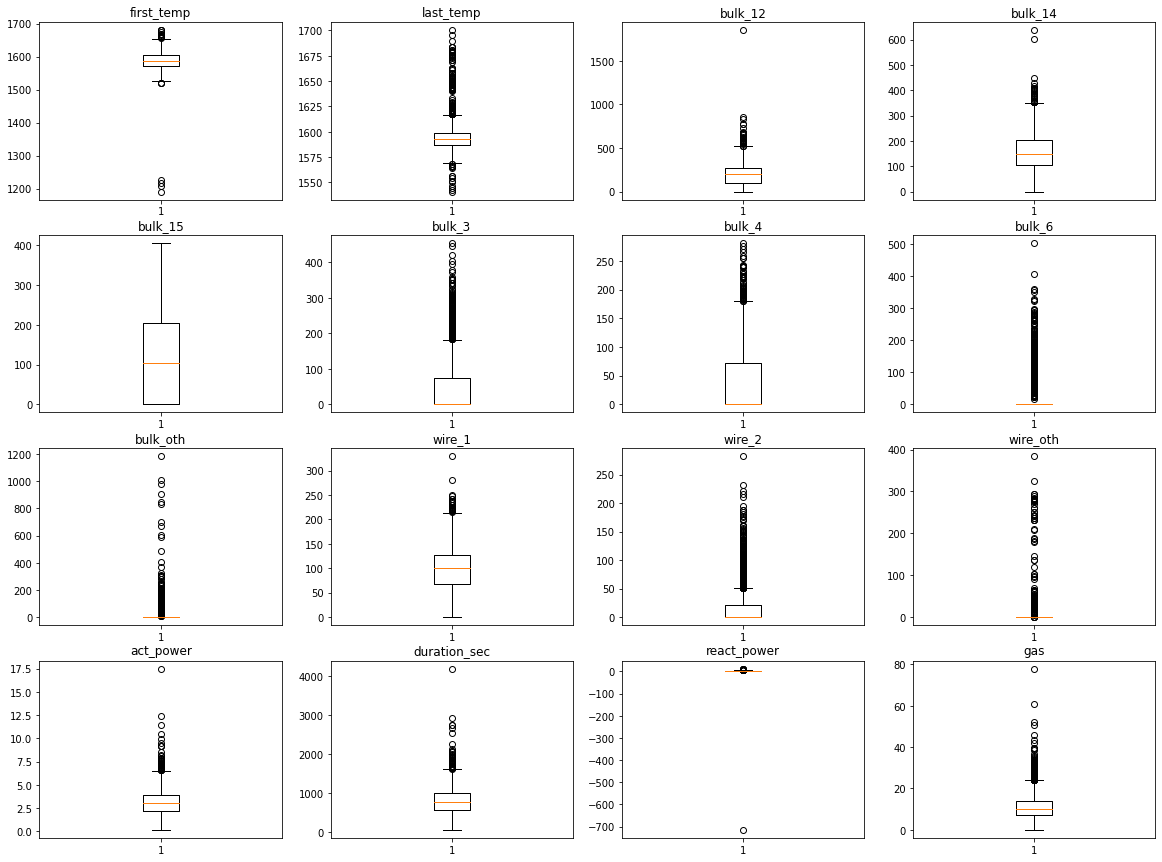

In [26]:
ls = df.columns.values
fig = plt.figure(figsize=(20, 15))

for i in range(len(ls)):
    el = ls[i]
    i += 1
    fig.add_subplot(4, 4, i)
    plt.boxplot(df[el])
    plt.title(el)
plt.show()

Как видно, по каждому из параметров присутствуют выбросы. Оценим долю выбросов в каждом из показателей.

In [27]:
for el in ls:
    boxplot = plt.boxplot(df[el])
    outliers = list(boxplot['fliers'][0].get_data()[1])
    print(f'{el}: {(len(outliers) / len(df)):.1%}')
    plt.close()

first_temp: 0.8%
last_temp: 7.9%
bulk_12: 1.4%
bulk_14: 1.3%
bulk_15: 0.0%
bulk_3: 6.8%
bulk_4: 2.4%
bulk_6: 17.9%
bulk_oth: 21.5%
wire_1: 1.1%
wire_2: 13.0%
wire_oth: 4.5%
act_power: 1.7%
duration_sec: 1.7%
react_power: 2.0%
gas: 4.2%


**Вывод**   
Для большинства наблюдений не свойственны добавления материалов, что приводит к смещению медианы к нулю, однако данные факторы важны для дальнейшего анализа => от этих выбросов мы избавляться не будем (переменные bulk, wire). Для остальных параметров выбросы целесообразно исключить.

In [28]:
ls = ['first_temp', 'last_temp', 'duration_sec', 'act_power', 'react_power', 'gas']
for el in ls:
    boxplot = plt.boxplot(df[el])
    outliers = list(boxplot['fliers'][0].get_data()[1])
    df = df[~df[el].isin(outliers)]
    plt.close()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 1 to 2474
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2121 non-null   int64  
 1   last_temp     2121 non-null   int64  
 2   bulk_12       2121 non-null   float64
 3   bulk_14       2121 non-null   float64
 4   bulk_15       2121 non-null   float64
 5   bulk_3        2121 non-null   float64
 6   bulk_4        2121 non-null   float64
 7   bulk_6        2121 non-null   float64
 8   bulk_oth      2121 non-null   float64
 9   wire_1        2121 non-null   float64
 10  wire_2        2121 non-null   float64
 11  wire_oth      2121 non-null   float64
 12  act_power     2121 non-null   float64
 13  duration_sec  2121 non-null   int64  
 14  react_power   2121 non-null   float64
 15  gas           2121 non-null   float64
dtypes: float64(13), int64(3)
memory usage: 281.7 KB


**Матрица корреляции**

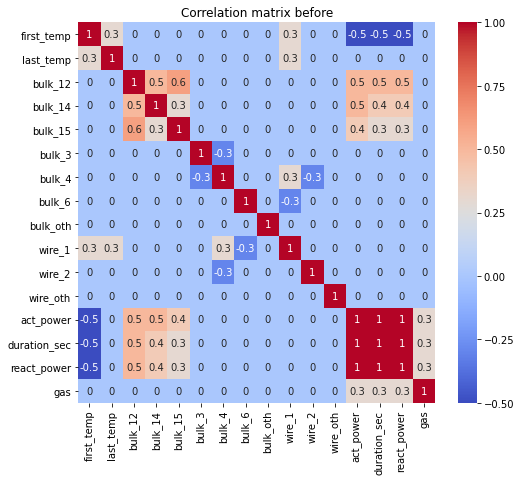

In [31]:
plt.figure(figsize=(8, 7))
cm = df.corr()
cm = np.round(cm, 1)
cm[np.abs(cm) < 0.3] = 0

fig.add_subplot(1, 2, 1)
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Correlation matrix before');

**Вывод**   
1. Показатели act_power, react_power, duration_sec сильно зависимы между собой => оставим только act_power
2. bulk_12 зависима с bulk_14 и bulk_15. Оставим bulk_14, так как имеет больше всех ненулевых наблюдений.

In [30]:
y = df['last_temp']
X = df.drop(['last_temp', 'react_power', 'duration_sec', 'bulk_12', 'bulk_15'], axis=1)
y.shape, X.shape

((2121,), (2121, 11))

Данные готовы к дальнейшему анализу и подбору модели.

## Выбор модели

В задачах регрессии выделяют следующие основные подходы:
1. Линейная регрессия (лин.зависимость).
2. Полиномиальная регрессия (нелин.зависимость).
3. Гребневая регрессия (высокая коллинеарность).
4. По методу лассо (высокая коллинеарность).
5. Эластичная сеть (высокая коллинеарность).

Поскольку в данных не наблюдается высокая коллинеарность, методы 3-5 оставим за скобками. К оставшимся базовым также добавим следующие модели:
1. Случайный лес с подбором гиперпараметров
2. KNN

Модель с наименьшей метрикой MAE будет выбрана для проверки на тестовой выборке.

In [31]:
#разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

#масштабируем переменные
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

**Линейная регрессия**

In [32]:
%%time
model = LinearRegression()
mae_lr = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
r2_lr = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
print(f'mae - {mae_lr:.2f}, r2 - {r2_lr:.2f}')

mae - 5.44, r2 - 0.38
CPU times: user 114 ms, sys: 34.6 ms, total: 149 ms
Wall time: 25.3 ms


**Полиномиальная регрессия**

In [33]:
def poly(X, degree):
    M = np.array([X ** n for n in range(1, degree + 1)]).transpose(1, 0, 2).reshape(len(X), -1)
    return pd.DataFrame(M, index=X.index)

In [34]:
%%time
model = LinearRegression()
mae_pr = 100
best_degree = 0
for i in range(1, 11):
    X_poly = poly(X_train, i)
    mae = cross_val_score(model, X_poly, y_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
    r2 = cross_val_score(model, X_poly, y_train, cv=5, scoring='r2').mean()
    if mae < mae_pr:
        mae_pr = mae
        r2_pr = r2
        best_degree = i
print(f'best degree - {best_degree}: mae - {mae_pr:.2f}, r2 - {r2_pr:.2f}')

best degree - 2: mae - 5.29, r2 - 0.39
CPU times: user 2.62 s, sys: 527 ms, total: 3.14 s
Wall time: 412 ms


**Случайный лес**

In [35]:
%%time
best_n = 0
best_depth = 0
mae_rf = 100
for n in range(1, 21):
    for d in range(1, 21):
        for f in range(1, X_train.shape[1] + 1):
            model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=17, max_features=f)
            mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
            r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
            if mae < mae_rf:
                best_n = n
                best_depth = d
                best_features = f
                mae_rf = mae
                r2_rf = r2
print(f'Количество деревьев - {best_n}, глубина - {best_depth}, max_features - {best_features}')
print(f'mae - {mae_rf:.2f}, r2 - {r2_rf:.2f}')

Количество деревьев - 20, глубина - 9, max_features - 9
mae - 5.36, r2 - 0.38
CPU times: user 17min 10s, sys: 4.34 s, total: 17min 14s
Wall time: 17min 13s


**KNN**

In [36]:
%%time
mae_knn = 100
r2_knn = 0
best_n = 0
for n in range(1, 11):
    model = KNeighborsRegressor(n_neighbors=n, weights='distance')
    mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    if mae < mae_knn:
        best_n = n
        mae_knn = mae
        r2_knn = r2
print(f'best_n = {best_n}, mae - {mae_knn:.2f}, r2 - {r2_knn:.2f}')

best_n = 8, mae - 5.83, r2 - 0.29
CPU times: user 732 ms, sys: 2.48 ms, total: 734 ms
Wall time: 733 ms


Сведем все результаты в единую таблицу.

In [37]:
index = ['Linear',
         'Polynom',
         'RandomForest',
         'KNN']
data = {'MAE':np.round([mae_lr,
               mae_pr,
               mae_rf,
               mae_knn],2),
       'R2':np.round([r2_lr,
             r2_pr,
             r2_rf,
             r2_knn],2)}
scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE,R2
Linear,5.44,0.38
Polynom,5.29,0.39
RandomForest,5.36,0.38
KNN,5.83,0.29


**Вывод**   
Наименьшее отклонение на обучающих данных показала модель полиномиальной регрессии второго порядка. Протестируем выбранную модель.

## Тест модели и выводы

In [38]:
#сгенерируем названия новых столбцов
ls = list(X_train.columns)
ls2 = []
for el in ls:
    ls2.append(el + '_2')
ls.extend(ls2)

#приведем признаки к полиномам второго порядка
X_train = poly(X_train, 2).reset_index(drop=True)
X_test = poly(X_test, 2).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#корректно назовем столбцы
X_train.columns = ls
X_test.columns = ls

#оценим модель
model = LinearRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print(f'mae - {mae:.2f}, r2 - {r2:.2f}')

mae - 5.09, r2 - 0.44


Модель оказалась устойчива и на тестовой выборке: показатель mae находится ниже референтного значения в 6.8   
Далее также взглянем на значимость факторов.

In [39]:
model_importances = pd.concat(
    [pd.DataFrame(X_train.columns),
     np.round(pd.DataFrame(abs(np.transpose(model.coef_))),2)],
     axis = 1
)
model_importances.columns = ['feature', 'importance']
model_importances = model_importances.sort_values(by='importance', ascending=True)

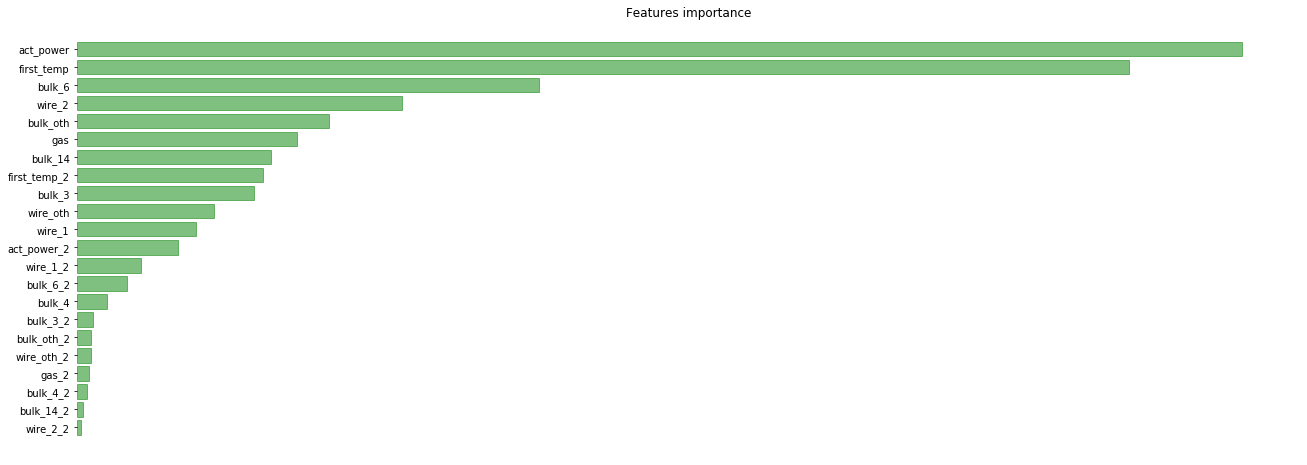

In [40]:
fig = plt.figure(figsize=(17, 6))
ax = fig.add_axes([0,0,1,1])
plt.barh(model_importances['feature'], 
         model_importances['importance'], 
         alpha=0.5,
         color='green',
         edgecolor='green')
plt.xticks([])
plt.title('Features importance')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.spines['left'].set_linewidth(False)
plt.show()

**Выводы**   
1. В показателях измерений температуры находится много пропусков - эту проблему необходимо адресовать.
2. Наилучшая модель из оцененных - полиномиальная регрессия второго порядка.
3. Наиболее значимые факторы - первоначальная температура нагрева и приложенная к нагреву мощность.
4. Ожидаемое абсолютное отклонение прогноза составляет 5 градусов.
5. Модель позволяет предсказать температуру стали на разных стадиях производства, что приведет к снижению потребления электроэнергии и соответствующих издержек.